In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

DATA_ROOT = Path(r"S:\Faculty of ai\third year\first term\deep learning\project\asl-sign-translator\data\chars\data_split")
SPLITS = ["train", "val", "test"]

assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"
print("DATA_ROOT:", DATA_ROOT)


DATA_ROOT: S:\Faculty of ai\third year\first term\deep learning\project\asl-sign-translator\data\chars\data_split


Build DataFrame

In [2]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

rows = []
for split in SPLITS:
    split_dir = DATA_ROOT / split
    if not split_dir.exists():
        print("Missing split:", split_dir)
        continue

    for cls_dir in split_dir.iterdir():
        if not cls_dir.is_dir():
            continue
        label = cls_dir.name
        for p in cls_dir.iterdir():
            if p.suffix.lower() in IMG_EXTS and p.is_file():
                rows.append({
                    "split": split,
                    "label": label,
                    "filename": p.name,
                    "path": str(p)
                })

df = pd.DataFrame(rows)
print("Total images:", len(df))
df.head()


Total images: 87000


,split,label,filename,path
0,train,A,A1.jpg,S:\Faculty of ai\third year\first term\deep le...
1,train,A,A1000.jpg,S:\Faculty of ai\third year\first term\deep le...
2,train,A,A1001.jpg,S:\Faculty of ai\third year\first term\deep le...
3,train,A,A1002.jpg,S:\Faculty of ai\third year\first term\deep le...
4,train,A,A1004.jpg,S:\Faculty of ai\third year\first term\deep le...


In [3]:
counts = df.groupby(["split","label"]).size().reset_index(name="count")
counts.sort_values(["split","count"], ascending=[True, False]).head(20)


,split,label,count
0,test,A,300
1,test,B,300
2,test,C,300
3,test,D,300
4,test,E,300
5,test,F,300
6,test,G,300
7,test,H,300
8,test,I,300
9,test,J,300


Plot

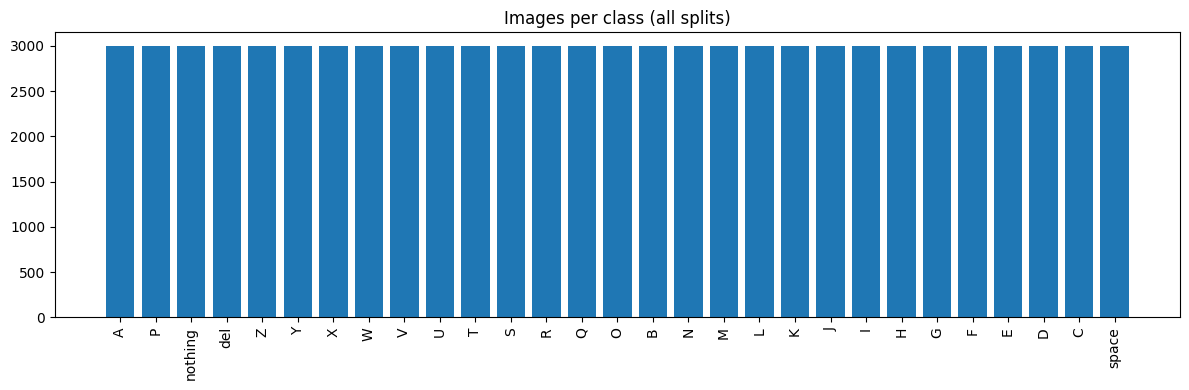

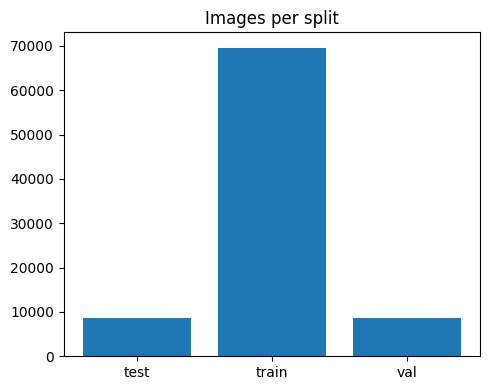

In [4]:

total_per_class = df.groupby("label").size().sort_values(ascending=False)

plt.figure(figsize=(12,4))
plt.bar(total_per_class.index, total_per_class.values)
plt.xticks(rotation=90)
plt.title("Images per class (all splits)")
plt.tight_layout()
plt.show()


total_per_split = df.groupby("split").size()
plt.figure(figsize=(5,4))
plt.bar(total_per_split.index, total_per_split.values)
plt.title("Images per split")
plt.tight_layout()
plt.show()


In [5]:
bad = []
for i, row in df.iterrows():
    try:
        with Image.open(row["path"]) as im:
            im.verify()  # verify header
    except Exception as e:
        bad.append((row["path"], str(e)))

print("Corrupted images:", len(bad))
bad[:10]


Corrupted images: 0


[]

Image Sizes Analysis

Sample size stats:
W min/mean/max: 200 200.0 200
H min/mean/max: 200 200.0 200


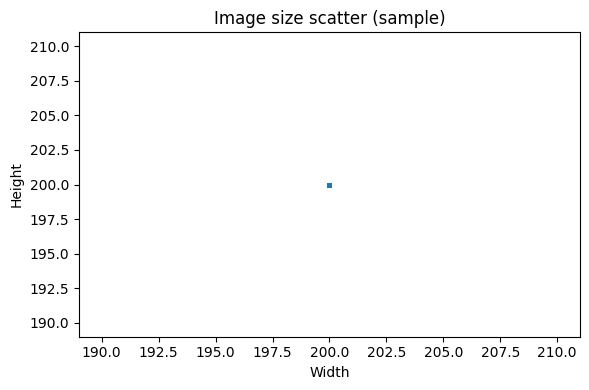

In [6]:
sizes = []
for p in df["path"].sample(min(2000, len(df)), random_state=42):  
    with Image.open(p) as im:
        sizes.append(im.size)  # (W,H)

sizes = np.array(sizes)
print("Sample size stats:")
print("W min/mean/max:", sizes[:,0].min(), sizes[:,0].mean(), sizes[:,0].max())
print("H min/mean/max:", sizes[:,1].min(), sizes[:,1].mean(), sizes[:,1].max())

plt.figure(figsize=(6,4))
plt.scatter(sizes[:,0], sizes[:,1], s=5)
plt.xlabel("Width"); plt.ylabel("Height")
plt.title("Image size scatter (sample)")
plt.tight_layout()
plt.show()


Show Samples per Class

In [7]:
def compute_mean_std(sample_n=5000):
    sample = df.sample(min(sample_n, len(df)), random_state=42)["path"].tolist()
    ch_sum = np.zeros(3)
    ch_sq  = np.zeros(3)
    n_pixels = 0

    for p in sample:
        img = np.array(Image.open(p).convert("RGB"), dtype=np.float32) / 255.0
        ch_sum += img.mean(axis=(0,1))
        ch_sq  += (img**2).mean(axis=(0,1))
    mean = ch_sum / len(sample)
    std  = np.sqrt(ch_sq / len(sample) - mean**2)
    return mean, std

mean, std = compute_mean_std(3000)
print("Mean:", mean)
print("Std :", std)


Mean: [0.51708775 0.49708519 0.51259855]
Std : [0.22666265 0.25450903 0.26212648]


In [8]:
OUT_EXCEL = DATA_ROOT.parent / "dataset_index.xlsx"  
print("Saving to:", OUT_EXCEL)

# Summary tables
summary_all = df.groupby("label").size().reset_index(name="total_count").sort_values("total_count", ascending=False)
summary_split = df.groupby(["split","label"]).size().reset_index(name="count")

with pd.ExcelWriter(OUT_EXCEL, engine="openpyxl") as writer:
   
    df.sort_values(["split","label","filename"]).to_excel(writer, sheet_name="all_images", index=False)

   
    summary_all.to_excel(writer, sheet_name="summary_total", index=False)
    summary_split.to_excel(writer, sheet_name="summary_by_split", index=False)

  
    MAKE_SHEET_PER_LABEL = True

    if MAKE_SHEET_PER_LABEL:
        for label, g in df.groupby("label"):
            
            sheet_name = str(label)[:31]
            g[["split","filename","path"]].to_excel(writer, sheet_name=sheet_name, index=False)

print(" Excel saved.")


Saving to: S:\Faculty of ai\third year\first term\deep learning\project\asl-sign-translator\data\chars\dataset_index.xlsx


ModuleNotFoundError: No module named 'openpyxl'